# Spatiotemporal Clustering of Land Cover Change 

### Preprocessing Steps

The example dataset used in this project is UAV multispectral imagery collected of Niwot Ridge, Colorado collected on a weekly basis between 21 June and 18 August 2017. 

Niwot Ridge is a highly remote alpine ecosystem, exhibiting interesting dynamics between snow cover and vegetation health. The multispectral imagery includes Red, Green, Blue, Red (Calibrated) and Near Infrared (NIR) (Calibrated), we are particularly interested in the Red and NIR bands for this example. The preprocessing steps include:

1. Import Libraries
2. Setting Project Parameters - first set the file paths, target resolution and configure the NDVI class mapping if you are using a different dataset
3. Calculate NDVI, Downsample NDVI Raster (optional) and Write as GeoTIFF to an output directory
4. Iterate over NDVI rasters from each date and create a land cover classification raster based on the NDVI class ranges defined in Step 2, write the GeoTIFFs to disk


### 1. Import Libraries

In [2]:
import rioxarray as rio
import os
from dask.distributed import Client, Lock
import xarray as xr
import numpy as np
from lc_spatiotemporal import ndvi, resample_da, get_raster_class
from xrspatial import zonal_stats
import pandas as pd
from shapely.geometry import shape
import geopandas as gpd
import json


### 2. Set Project Parameters

These are initial variables required to run the remaining processes. The land cover class dictionary was set up following visual inspection of the RGB rasters and NDVI maps. If using a different dataset you may need to do this first to determine which classes are present. If you have a land cover dataset already, you can skip the land cover class dictionary setup step.

In [3]:

# FILE PATHS, RASTER BAND NAMING AND TARGET RESOLUTION
# =============================================================================================================================================================================================================
# Map bands index to band name: R = Red, G= Green, B= Blue, RC = Red-Calibrated, NIR = NIR-Calibrated 
# For more details on  bands used for the example dataset, refer to Table 2 in Wigmore and Molotch (2023) https://doi.org/10.5194/essd-15-1733-2023
BANDS=["R","G","B","RC","NIR"] 
MULTIB_DIR="../../data/UAV_Mapping_Niwot_Ridge_Colorado_2021/UAV_MULTISPEC" # Path to Multispectral GeoTIFF Files, each file is named by the capture date in format YYYYMMDD
OUTPUT_DIR="output" # Output directory for derived NDVI and Land Cover classification, the script will create the directory if it doesn't exist
TARGET_RESOLUTION=0.25 # target resolution in METERS, ensure you are using a CRS Project in meters, not degrees

ORTHO_FILES=[f"{MULTIB_DIR}/{x}" for x in os.listdir(MULTIB_DIR) if x.split(".")[-1] == "tif"] # List of paths for all mutlispectral orthomosaics 
ORTHO_FILES.sort()
DATES=[file.split("/")[-1].split("_")[0] for file in ORTHO_FILES] # Retrieve dates in YYYYMMDD

if not os.path.exists(OUTPUT_DIR): # # Create output directory if doesn't already exist
    os.mkdir(OUTPUT_DIR)


# LAND COVER CLASS DICTIONARY SETUP
# =============================================================================================================================================================================================================
CLASS_MAP=dict()
CLASSES=["Dense Vegetation","Moderate Vegetation","Sparse Vegetation","Snow"] # List of Land Cover class labels to apply to NDVI dataset
VALUES=range(1, len(CLASSES) + 1) # Based on CLASSES list, an array of class numbers will be generated, starting from 1 since 0 will be used as FillValue
NDVI_RANGES=[[0.6,1], [0.3,0.6], [0.2,0.3], [-1,0.2]] # NDVI value range for Dense Vegetation, Moderate Vegetation, Sparse Vegetation and Snow, according to NASA Earth Observatory
CLASS_ITEMS=[{"value" : vl, "range" : rg} for vl,rg in zip(VALUES, NDVI_RANGES)]

# Set up a dictionary to map class labels to their numeric values and NDVI range
for cl_name,item in zip(CLASSES, CLASS_ITEMS):
    CLASS_MAP.update({cl_name: item})
    
# Export class mapping as JSON
with open("classes.json","w") as json_out:
    json_out.write(json.dumps(CLASSES))





### 3. Calculate NDVI and Downsample to 25cm


In [4]:
# Instantiate the Dask Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit='10GB')


# Iterate over all multispectral images in the directory, calculated NDVI and downsample to 25 cm resolution
for ortho_file,date in zip(ORTHO_FILES,DATES):

    
    ndvi_out=f"{OUTPUT_DIR}/{date}_ndvi_25cm.tif"

    # Read Multspectral Ortho as DaskArray
    ortho=rio.open_rasterio(ortho_file, chunks=True,  lock=Lock("rio-read")) # Read ortho as DaskArray
    fill_value=ortho.attrs["_FillValue"]
    ortho=ortho.assign_coords(band=BANDS) # Assign band names to orthomosaic - 1 = R, 2 = G, 3 = B, 4 = RC, 5 = NIR

    # Removing these keys as they cause issues with writing the final output
    if "long_name" in ortho.attrs:
        del ortho.attrs["long_name"]
        del ortho.attrs["units"]

    # Retrieve NIR Band (5)
    nir=ortho.sel(band="NIR")
    nir=nir.where(nir != fill_value)

    # Retrieve Calibrated Red Band (4)
    red=ortho.sel(band="RC")
    red=red.where(red != fill_value)

    # Calculate NDVI
    ndvi_5cm = ndvi(nir,red)
    ndvi_5cm.attrs=ortho.attrs # Pass original Orthomosaic Attributes to derived NDVI DataArray
    print(f"{date} NDVI Calculation Complete")
    ortho.close() # Close original ortho to free memory

    ndvi_5cm=ndvi_5cm.expand_dims(dim="band",axis=0) # Reshape array to (band, height, width)
    ndvi_5cm=ndvi_5cm.assign_coords(band=["NDVI"]) # Rename band to NDVI

    # Write NDVI Output at target resolution
    if os.path.exists(ndvi_out) == False:
        ndvi_25cm=resample_da(ndvi_5cm, target_res=TARGET_RESOLUTION) # Resamle NDVI Layer from 5cm to 25cm
        ndvi_5cm.close() 
        # ndvi_25cm.rio.to_raster(ndvi_out) # Write resampled NDVI Raster to GeoTIFF
        print (f"{date} NDVI GeoTIFF Exported")



20170621 NDVI Calculation Complete
20170627 NDVI Calculation Complete
20170705 NDVI Calculation Complete
20170711 NDVI Calculation Complete
20170718 NDVI Calculation Complete
20170725 NDVI Calculation Complete
20170814 NDVI Calculation Complete


### 4. Classify Snow, Dense Vegetation and Sparse Vegetation Based on NDVI



The Normalized Difference Vegetation Index (NDVI) is a widely used indicator for assessing vegetation health and density. NDVI values range from -1.0 to 1.0, with different ranges corresponding to various surface features and vegetation types:

- Negative values: Indicate non-vegetated surfaces such as water bodies, clouds, or snow.
- Values close to 0: Represent barren areas like rocks, sand, or snow.
- Low positive values (approximately 0.2 to 0.3): Correspond to shrublands and grasslands.
- Moderate values (around 0.3 to 0.5): Indicate areas with sparse vegetation or transitional zones.
- High values (approximately 0.6 to 0.8): Signify dense vegetation, such as temperate and tropical forests.

[Source: NASA Earth Observatory](https://earthobservatory.nasa.gov/features/MeasuringVegetation)


In [5]:

ndvi_files=[f"{OUTPUT_DIR}/{x}" for x in os.listdir(OUTPUT_DIR) if "ndvi" in x and x.split(".")[-1] =="tif"]

for ndvi_file in ndvi_files:   

    
    date=ndvi_file.split("/")[-1].split("_")[0]
    lc_out=f"{OUTPUT_DIR}/{date}_lc_25cm.tif"
    
    ndvi_25cm=rio.open_rasterio(ndvi_file)

    lc_classified=[get_raster_class(raster=ndvi_25cm,
                                    val=CLASS_MAP[cl_name]["value"],
                                    range=CLASS_MAP[cl_name]["range"])  for cl_name in CLASS_MAP.keys()]

    # LAND COVER LAYER - Aggregate all four land classification layers to create a single land cover raster dataset
    lc = sum(lc_classified)
    lc=lc.where(lc > 0) # Mask out 0 (FillValue)
    print(f"{date} Land Cover Classification Complete")

    # Write classified Land Cover Raster
    if os.path.exists(lc_out) == False:    
      # lc.rio.to_raster(lc_out) # Export as GeoTIFF  
      print(f"{date} GeoTIFF Export Complete")




20170621 Land Cover Classification Complete
20170627 Land Cover Classification Complete
20170705 Land Cover Classification Complete
20170711 Land Cover Classification Complete
20170718 Land Cover Classification Complete
20170725 Land Cover Classification Complete
20170814 Land Cover Classification Complete


By comparing the RGB orthomosaics and NDVI from the Niwot Ridge dataset, we can clearly see snow indicated by low NDVI values of < 0.1. It is also clear that forested areas seem to have NDVI values of >0.6 

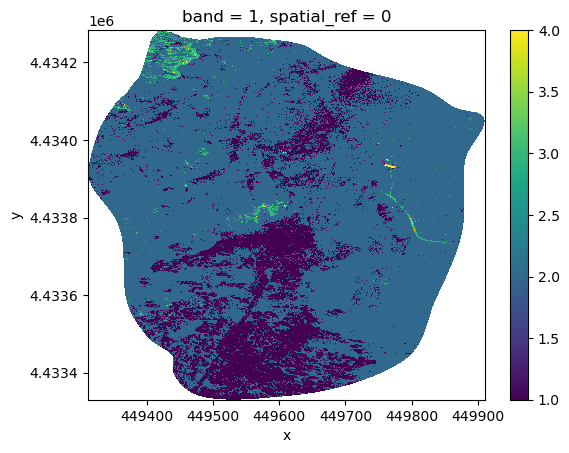

In [6]:
lc.plot()

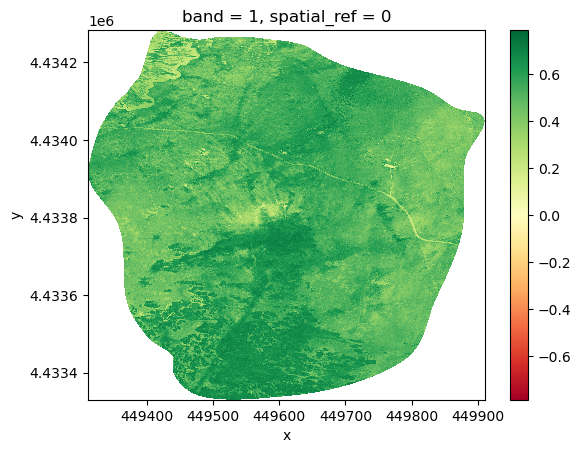

In [8]:
ndvi_25cm.plot(cmap="RdYlGn")